In [126]:
# =============================================================================
# 📊 Titanic Dataset - Complete Data Preprocessing Pipeline
# =============================================================================
# 
# LEARNING OBJECTIVES:
# After completing this notebook, you will understand:
# ✅ How to load and explore a dataset
# ✅ Techniques for handling missing values (median, mode, dropping)
# ✅ When to use Label Encoding vs One-Hot Encoding
# ✅ How and when to apply StandardScaler vs MinMaxScaler
# ✅ Best practices to avoid data leakage
#
# =============================================================================
# WHY DATA PREPROCESSING?
# =============================================================================
# Machine Learning algorithms work with NUMBERS, not text or missing values.
# Raw data often contains:
#   - Missing values (NaN) → Models can't process these
#   - Categorical text (male/female) → Need to convert to numbers
#   - Features at different scales (Age: 0-80, Fare: 0-500) → Can bias some models
#
# PREPROCESSING WORKFLOW:
# 1. Load & Explore → Understand your data first!
# 2. Handle Missing Values → Imputation or removal
# 3. Encode Categoricals → Convert text to numbers
# 4. Scale Features → Normalize ranges for certain algorithms
# =============================================================================

import pandas as pd

# Load Titanic dataset from a CSV file
# The Titanic dataset is a classic ML dataset for binary classification
# Task: Predict if a passenger survived (1) or not (0)
titanic_data = pd.read_csv('Titanic-Dataset.csv')

# Display the first 10 rows to understand the data structure
# COLUMN DESCRIPTIONS:
# - PassengerId: Unique identifier (not useful for prediction)
# - Survived: TARGET VARIABLE (0 = No, 1 = Yes)
# - Pclass: Ticket class (1 = 1st/Upper, 2 = 2nd/Middle, 3 = 3rd/Lower)
# - Name: Passenger name (high cardinality, not directly useful)
# - Sex: Gender (male/female) - IMPORTANT feature!
# - Age: Age in years (has missing values)
# - SibSp: # of siblings/spouses aboard
# - Parch: # of parents/children aboard
# - Ticket: Ticket number (high cardinality, not useful)
# - Fare: Passenger fare (continuous numerical)
# - Cabin: Cabin number (many missing values)
# - Embarked: Port of embarkation (C=Cherbourg, Q=Queenstown, S=Southampton)
titanic_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [127]:
# =============================================================================
# STEP 1: Understand Dataset Dimensions
# =============================================================================
# Always check the shape of your data first!
# shape returns (rows, columns) = (samples, features)

print(f"Dataset shape: {titanic_data.shape}")
print(f"→ {titanic_data.shape[0]} passengers (samples)")
print(f"→ {titanic_data.shape[1]} columns (11 features + 1 target)")

# RULE OF THUMB for ML:
# - More samples = better model generalization (usually need 10x features minimum)
# - Too many features with few samples = risk of overfitting
# - Here: 891 samples, 11 features → Good ratio!

Dataset shape: (891, 12)
→ 891 passengers (samples)
→ 12 columns (11 features + 1 target)


In [128]:
# =============================================================================
# STEP 2: Explore Unique Values (Cardinality Analysis)
# =============================================================================
# WHY CHECK UNIQUE VALUES?
# - Helps identify feature TYPES:
#   → Low cardinality (2-10 unique): Likely categorical → Needs encoding
#   → High cardinality (many unique): Likely numerical OR unusable identifier
#
# - Helps identify USELESS features:
#   → PassengerId: 891 unique = each row is unique → Just an ID, DROP IT
#   → Name: 891 unique = each row is unique → DROP IT (or extract titles)
#   → Ticket: 681 unique = almost unique → DROP IT
#
# DECISION MAKING:
# - Sex (2 unique): Binary categorical → Use Label Encoding
# - Embarked (3 unique): Multi-class categorical → Use One-Hot Encoding
# - Pclass (3 unique): Ordinal but treated as categorical → One-Hot Encoding
# - Survived (2 unique): TARGET variable (don't encode, this is what we predict!)

print("=" * 50)
print("CARDINALITY ANALYSIS (Unique Values per Column)")
print("=" * 50)

for column in titanic_data.columns:
    unique_count = titanic_data[column].nunique()
    dtype = titanic_data[column].dtype
    
    # Classify the column type
    if unique_count <= 2:
        category = "Binary"
    elif unique_count <= 10:
        category = "Low cardinality (Categorical)"
    elif unique_count <= 50:
        category = "Medium cardinality"
    else:
        category = "High cardinality (ID/Drop?)"
    
    print(f"{column:15} | {unique_count:4} unique | {str(dtype):8} | {category}")

CARDINALITY ANALYSIS (Unique Values per Column)
PassengerId     |  891 unique | int64    | High cardinality (ID/Drop?)
Survived        |    2 unique | int64    | Binary
Pclass          |    3 unique | int64    | Low cardinality (Categorical)
Name            |  891 unique | object   | High cardinality (ID/Drop?)
Sex             |    2 unique | object   | Binary
Age             |   88 unique | float64  | High cardinality (ID/Drop?)
SibSp           |    7 unique | int64    | Low cardinality (Categorical)
Parch           |    7 unique | int64    | Low cardinality (Categorical)
Ticket          |  681 unique | object   | High cardinality (ID/Drop?)
Fare            |  248 unique | float64  | High cardinality (ID/Drop?)
Cabin           |  147 unique | object   | High cardinality (ID/Drop?)
Embarked        |    3 unique | object   | Low cardinality (Categorical)


In [129]:
# =============================================================================
# STEP 3: Check for Missing Values
# =============================================================================
# WHY IS THIS CRITICAL?
# - Most ML algorithms CANNOT handle NaN/null values
# - Missing data can lead to: errors, biased models, or incorrect predictions
#
# STRATEGIES FOR HANDLING MISSING VALUES:
# ┌──────────────────┬─────────────────────────────────────────────────────┐
# │ Strategy         │ When to Use                                         │
# ├──────────────────┼─────────────────────────────────────────────────────┤
# │ Drop rows        │ Very few missing (<5%), data is abundant            │
# │ Drop column      │ >50% missing, or feature is not important           │
# │ Mean imputation  │ Numerical, normally distributed                     │
# │ Median imputation│ Numerical, skewed distribution (robust to outliers) │
# │ Mode imputation  │ Categorical features                                │
# │ Forward/Backward │ Time series data                                    │
# │ ML imputation    │ Complex patterns (e.g., KNN, regression)            │
# └──────────────────┴─────────────────────────────────────────────────────┘

print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

total_rows = len(titanic_data)
for column in titanic_data.columns:
    missing = titanic_data[column].isnull().sum()
    pct = (missing / total_rows) * 100
    
    # Decision recommendation
    if missing == 0:
        action = "✓ No action needed"
    elif pct > 50:
        action = "→ DROP COLUMN (too many missing)"
    elif pct < 5:
        action = "→ Impute with mode/median"
    else:
        action = "→ Impute with median (numerical) or mode (categorical)"
    
    print(f"{column:15} | {missing:4} missing | {pct:5.1f}% | {action}")

print("\n" + "=" * 60)
print("IMPUTATION PLAN:")
print("  • Age: 19.9% missing → Impute with MEDIAN (skewed distribution)")
print("  • Cabin: 77.1% missing → DROP COLUMN (too much missing)")
print("  • Embarked: 0.2% missing → Impute with MODE (categorical)")
print("=" * 60)

MISSING VALUES ANALYSIS
PassengerId     |    0 missing |   0.0% | ✓ No action needed
Survived        |    0 missing |   0.0% | ✓ No action needed
Pclass          |    0 missing |   0.0% | ✓ No action needed
Name            |    0 missing |   0.0% | ✓ No action needed
Sex             |    0 missing |   0.0% | ✓ No action needed
Age             |  177 missing |  19.9% | → Impute with median (numerical) or mode (categorical)
SibSp           |    0 missing |   0.0% | ✓ No action needed
Parch           |    0 missing |   0.0% | ✓ No action needed
Ticket          |    0 missing |   0.0% | ✓ No action needed
Fare            |    0 missing |   0.0% | ✓ No action needed
Cabin           |  687 missing |  77.1% | → DROP COLUMN (too many missing)
Embarked        |    2 missing |   0.2% | → Impute with mode/median

IMPUTATION PLAN:
  • Age: 19.9% missing → Impute with MEDIAN (skewed distribution)
  • Cabin: 77.1% missing → DROP COLUMN (too much missing)
  • Embarked: 0.2% missing → Impute with MODE

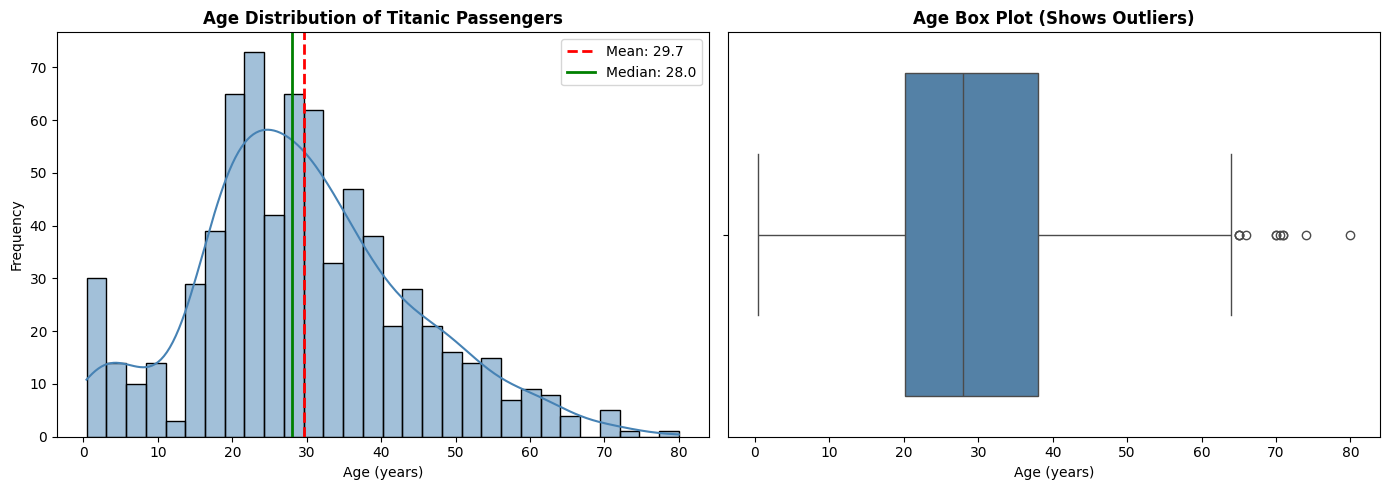

In [130]:
# =============================================================================
# STEP 4: Visualize Distributions Before Imputation
# =============================================================================
# WHY VISUALIZE?
# - Helps choose the RIGHT imputation strategy
# - Reveals outliers that might affect model performance
#
# MEAN vs MEDIAN:
# ┌─────────────────────────────────────────────────────────────────┐
# │ Distribution Type  │ Best Imputation │ Why?                     │
# ├────────────────────┼─────────────────┼──────────────────────────┤
# │ Normal (symmetric) │ MEAN            │ Mean = Median = Mode     │
# │ Skewed (asymmetric)│ MEDIAN          │ Median is robust to      │
# │                    │                 │ outliers/extreme values  │
# └─────────────────────────────────────────────────────────────────┘
#
# The Age distribution is RIGHT-SKEWED (tail extends to the right)
# → We'll use MEDIAN for imputation

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Histogram with KDE
ax1 = axes[0]
sns.histplot(titanic_data['Age'].dropna(), bins=30, kde=True, ax=ax1, color='steelblue')
ax1.axvline(titanic_data['Age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {titanic_data["Age"].mean():.1f}')
ax1.axvline(titanic_data['Age'].median(), color='green', linestyle='-', linewidth=2, label=f'Median: {titanic_data["Age"].median():.1f}')
ax1.set_title('Age Distribution of Titanic Passengers', fontsize=12, fontweight='bold')
ax1.set_xlabel('Age (years)')
ax1.set_ylabel('Frequency')
ax1.legend()

# Right plot: Box plot to show outliers
ax2 = axes[1]
sns.boxplot(x=titanic_data['Age'].dropna(), ax=ax2, color='steelblue')
ax2.set_title('Age Box Plot (Shows Outliers)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Age (years)')

plt.tight_layout()
plt.show()

# KEY INSIGHT:
# Notice how Mean > Median? This confirms RIGHT SKEW
# Outliers (elderly passengers) pull the mean up
# Median is more representative of the "typical" passenger age

C:\Users\shari\AppData\Local\Temp\ipykernel_19888\3785428777.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Embarked', data=titanic_data, ax=ax1, palette=colors, order=['S', 'C', 'Q'])


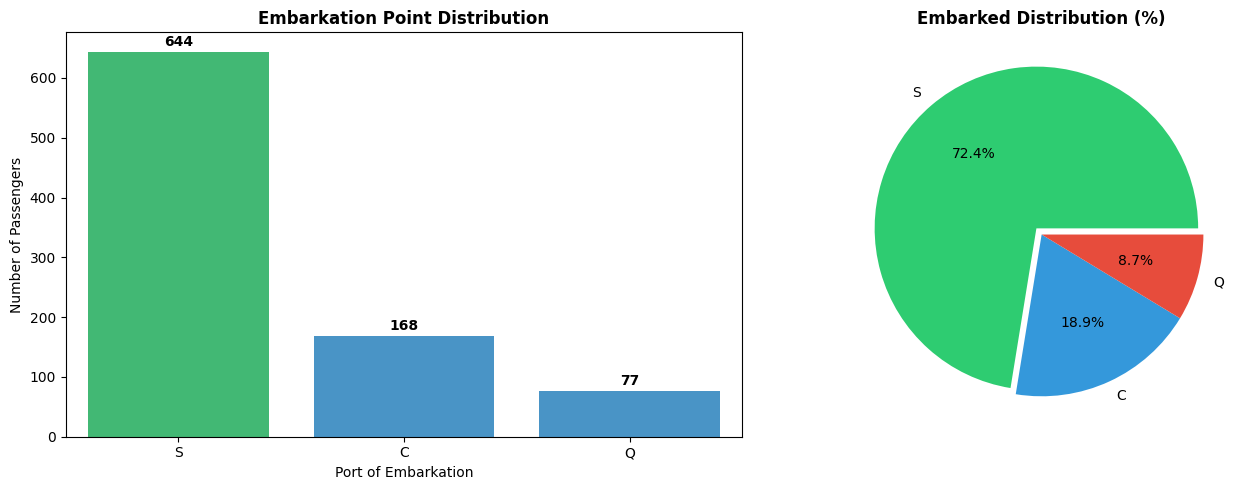


Mode of Embarked: 'S' (Southampton)
→ Missing values will be imputed with 'S'


In [131]:
# =============================================================================
# Visualize Categorical Feature: Embarked
# =============================================================================
# For CATEGORICAL features with missing values, we use MODE (most frequent value)
# This makes sense because we're assigning the most likely category
#
# EMBARKED PORT CODES:
# - S = Southampton (England) - Most passengers boarded here
# - C = Cherbourg (France)
# - Q = Queenstown (Ireland)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Count plot showing distribution
ax1 = axes[0]
embarked_counts = titanic_data['Embarked'].value_counts()
colors = ['#2ecc71' if x == embarked_counts.idxmax() else '#3498db' for x in embarked_counts.index]
sns.countplot(x='Embarked', data=titanic_data, ax=ax1, palette=colors, order=['S', 'C', 'Q'])
ax1.set_title('Embarkation Point Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Port of Embarkation')
ax1.set_ylabel('Number of Passengers')

# Add count labels on bars
for i, (idx, count) in enumerate(embarked_counts.reindex(['S', 'C', 'Q']).items()):
    ax1.text(i, count + 10, f'{count}', ha='center', fontweight='bold')

# Right: Pie chart showing percentages
ax2 = axes[1]
titanic_data['Embarked'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    ax=ax2, 
    colors=['#2ecc71', '#3498db', '#e74c3c'],
    explode=(0.05, 0, 0)
)
ax2.set_title('Embarked Distribution (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# MODE IMPUTATION DECISION:
# Southampton (S) is the mode with 72.4% of passengers
# The 2 missing values will be filled with 'S'
print(f"\nMode of Embarked: '{titanic_data['Embarked'].mode()[0]}' (Southampton)")
print("→ Missing values will be imputed with 'S'")

In [132]:
# =============================================================================
# STEP 5: Handle Missing Values (Imputation)
# =============================================================================
# IMPLEMENTATION OF OUR IMPUTATION PLAN:
#
# 1. Age (177 missing, 19.9%)
#    → Strategy: MEDIAN imputation
#    → Why: Skewed distribution, median is robust to outliers
#
# 2. Embarked (2 missing, 0.2%)
#    → Strategy: MODE imputation
#    → Why: Categorical feature, use most frequent category
#
# 3. Cabin (687 missing, 77.1%)
#    → Strategy: DROP COLUMN
#    → Why: Too much missing data to impute reliably
#
# IMPORTANT CONCEPT - DATA LEAKAGE WARNING:
# In production, you should calculate median/mode ONLY on training data,
# then apply the same values to test data. Here we're doing EDA, so it's okay.
# =============================================================================

print("=" * 60)
print("APPLYING IMPUTATION STRATEGIES")
print("=" * 60)

# 1. AGE: Impute with median
age_median = titanic_data['Age'].median()
missing_before = titanic_data['Age'].isnull().sum()
titanic_data['Age'] = titanic_data['Age'].fillna(age_median)
print(f"\n[AGE] Median imputation:")
print(f"  • Median value: {age_median} years")
print(f"  • Rows imputed: {missing_before}")

# 2. EMBARKED: Impute with mode
embarked_mode = titanic_data['Embarked'].mode()[0]  # mode() returns a Series, [0] gets first value
missing_before = titanic_data['Embarked'].isnull().sum()
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(embarked_mode)
print(f"\n[EMBARKED] Mode imputation:")
print(f"  • Mode value: '{embarked_mode}' (Southampton)")
print(f"  • Rows imputed: {missing_before}")

# 3. CABIN: Drop the column entirely
print(f"\n[CABIN] Dropping column:")
print(f"  • Reason: {687} missing values (77.1%)")
print(f"  • Too sparse to impute reliably")
titanic_data = titanic_data.drop(columns=['Cabin'])

# VERIFICATION: Confirm no missing values remain
print("\n" + "=" * 60)
print("VERIFICATION: Missing Values After Imputation")
print("=" * 60)
missing_total = titanic_data.isnull().sum().sum()
print(f"Total missing values: {missing_total}")

if missing_total == 0:
    print("✓ SUCCESS: All missing values have been handled!")
else:
    print("✗ WARNING: Some missing values remain!")
    print(titanic_data.isnull().sum())

APPLYING IMPUTATION STRATEGIES

[AGE] Median imputation:
  • Median value: 28.0 years
  • Rows imputed: 177

[EMBARKED] Mode imputation:
  • Mode value: 'S' (Southampton)
  • Rows imputed: 2

[CABIN] Dropping column:
  • Reason: 687 missing values (77.1%)
  • Too sparse to impute reliably

VERIFICATION: Missing Values After Imputation
Total missing values: 0
✓ SUCCESS: All missing values have been handled!


In [133]:
# =============================================================================
# STEP 6: Categorical Feature Analysis (Before Encoding)
# =============================================================================
# WHY DO WE NEED TO ENCODE CATEGORICAL FEATURES?
# - ML algorithms understand NUMBERS, not text
# - "male"/"female" must become 0/1 or similar numeric representation
#
# TWO MAIN ENCODING TECHNIQUES:
# ┌────────────────────┬────────────────────────────────────────────────────┐
# │ Label Encoding     │ One-Hot Encoding (Dummy Variables)                 │
# ├────────────────────┼────────────────────────────────────────────────────┤
# │ Maps categories    │ Creates binary column for EACH category           │
# │ to integers:       │                                                    │
# │ A→0, B→1, C→2     │ A→[1,0,0], B→[0,1,0], C→[0,0,1]                   │
# ├────────────────────┼────────────────────────────────────────────────────┤
# │ USE WHEN:          │ USE WHEN:                                          │
# │ • Binary (2 cats)  │ • Non-ordinal multi-class (no inherent order)     │
# │ • Ordinal (order   │ • Nominal categories (no ranking)                  │
# │   matters: Low,    │ • Tree-based models handle both well               │
# │   Medium, High)    │                                                    │
# ├────────────────────┼────────────────────────────────────────────────────┤
# │ PROBLEM:           │ PROBLEM:                                           │
# │ Implies ordering   │ Increases dimensionality                           │
# │ A<B<C (may be      │ (100 categories = 100 new columns!)               │
# │ incorrect!)        │                                                    │
# └────────────────────┴────────────────────────────────────────────────────┘

print("=" * 60)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 60)

categorical_features = ['Sex', 'Embarked', 'Pclass']

for feature in categorical_features:
    print(f"\n{'─' * 40}")
    print(f"Feature: {feature}")
    print(f"{'─' * 40}")
    
    # Value counts
    value_counts = titanic_data[feature].value_counts()
    print("Distribution:")
    for val, count in value_counts.items():
        pct = (count / len(titanic_data)) * 100
        print(f"  {val}: {count} ({pct:.1f}%)")
    
    # Encoding recommendation
    if feature == 'Sex':
        print(f"\n→ Encoding: LABEL ENCODING")
        print(f"  Reason: Binary feature (only 2 categories)")
        print(f"  Result: female→0, male→1")
    elif feature == 'Pclass':
        print(f"\n→ Encoding: ONE-HOT ENCODING")
        print(f"  Reason: Although ordinal (1>2>3), treating as nominal")
        print(f"  Result: Pclass_1, Pclass_2, Pclass_3 columns")
    else:
        print(f"\n→ Encoding: ONE-HOT ENCODING")
        print(f"  Reason: Nominal (no inherent order between ports)")
        print(f"  Result: Embarked_C, Embarked_Q, Embarked_S columns")

CATEGORICAL FEATURES ANALYSIS

────────────────────────────────────────
Feature: Sex
────────────────────────────────────────
Distribution:
  male: 577 (64.8%)
  female: 314 (35.2%)

→ Encoding: LABEL ENCODING
  Reason: Binary feature (only 2 categories)
  Result: female→0, male→1

────────────────────────────────────────
Feature: Embarked
────────────────────────────────────────
Distribution:
  S: 646 (72.5%)
  C: 168 (18.9%)
  Q: 77 (8.6%)

→ Encoding: ONE-HOT ENCODING
  Reason: Nominal (no inherent order between ports)
  Result: Embarked_C, Embarked_Q, Embarked_S columns

────────────────────────────────────────
Feature: Pclass
────────────────────────────────────────
Distribution:
  3: 491 (55.1%)
  1: 216 (24.2%)
  2: 184 (20.7%)

→ Encoding: ONE-HOT ENCODING
  Reason: Although ordinal (1>2>3), treating as nominal
  Result: Pclass_1, Pclass_2, Pclass_3 columns


In [134]:
# =============================================================================
# STEP 7A: Label Encoding (for Binary Features)
# =============================================================================
# LABEL ENCODING converts text categories to integers
# 
# HOW IT WORKS:
#   Categories are sorted alphabetically, then assigned numbers:
#   female → 0 (comes first alphabetically)
#   male → 1 (comes second alphabetically)
#
# SKLEARN's LabelEncoder:
#   - fit(): Learns the unique categories
#   - transform(): Converts categories to numbers
#   - fit_transform(): Does both in one step
#   - inverse_transform(): Converts numbers back to categories
#
# WHEN TO USE LABEL ENCODING:
# ✓ Binary features (only 2 categories) - like Sex
# ✓ Ordinal features with inherent order (Low < Medium < High)
# ✓ Target variable encoding
#
# WHEN TO AVOID:
# ✗ Multi-class nominal features (no order) - use One-Hot instead
#   Example: If we label encode colors as Red=0, Blue=1, Green=2
#   The model might incorrectly learn that Green > Blue > Red
# =============================================================================

from sklearn.preprocessing import LabelEncoder

# Create encoder instance
label_encoder = LabelEncoder()

# Apply Label Encoding to Sex column
# Before: 'female', 'male' (strings)
# After: 0, 1 (integers)
print("BEFORE Label Encoding:")
print(titanic_data['Sex'].head(10).tolist())

titanic_data['Sex'] = label_encoder.fit_transform(titanic_data['Sex'])

print("\nAFTER Label Encoding:")
print(titanic_data['Sex'].head(10).tolist())

# Understanding the mapping
print("\n" + "=" * 50)
print("ENCODING MAPPING:")
print("=" * 50)
print(f"Classes found: {label_encoder.classes_}")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  '{class_name}' → {i}")

# Demonstrate inverse transform (useful for interpretability)
print("\n" + "=" * 50)
print("INVERSE TRANSFORM (decode back to original):")
print("=" * 50)
sample_encoded = [0, 1, 1, 0]
sample_decoded = label_encoder.inverse_transform(sample_encoded)
print(f"Encoded: {sample_encoded}")
print(f"Decoded: {list(sample_decoded)}")

titanic_data.head(10)

BEFORE Label Encoding:
['male', 'female', 'female', 'female', 'male', 'male', 'male', 'male', 'female', 'female']

AFTER Label Encoding:
[1, 0, 0, 0, 1, 1, 1, 1, 0, 0]

ENCODING MAPPING:
Classes found: ['female' 'male']
  'female' → 0
  'male' → 1

INVERSE TRANSFORM (decode back to original):
Encoded: [0, 1, 1, 0]
Decoded: ['female', 'male', 'male', 'female']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S
5,6,0,3,"Moran, Mr. James",1,28.0,0,0,330877,8.4583,Q
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,S
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,C


In [135]:
# =============================================================================
# STEP 7B: One-Hot Encoding (for Multi-class Nominal Features)
# =============================================================================
# ONE-HOT ENCODING creates a new binary column for each category
#
# HOW IT WORKS:
#   Original: Embarked = [S, C, Q]
#   After One-Hot:
#   ┌───────────┬───────────┬───────────┐
#   │Embarked_S │Embarked_C │Embarked_Q │
#   ├───────────┼───────────┼───────────┤
#   │    1      │    0      │    0      │  ← Passenger embarked at Southampton
#   │    0      │    1      │    0      │  ← Passenger embarked at Cherbourg
#   │    0      │    0      │    1      │  ← Passenger embarked at Queenstown
#   └───────────┴───────────┴───────────┘
#
# WHY USE ONE-HOT ENCODING?
# - Avoids false ordering (Label Encoding implies S > C > Q which is wrong)
# - Each category is treated equally/independently
# - Works well with linear models (each category gets its own weight)
#
# POTENTIAL ISSUES:
# 1. MULTICOLLINEARITY (Dummy Variable Trap):
#    If you know Embarked_S=0 and Embarked_C=0, you know Embarked_Q=1
#    Solution: drop_first=True (drops one column to avoid redundancy)
#    Not always needed for tree-based models
#
# 2. HIGH CARDINALITY:
#    100 categories = 100 new columns! (curse of dimensionality)
#    Solution: Use target encoding or frequency encoding
#
# METHODS:
# - pd.get_dummies(): Simple, built into pandas
# - sklearn OneHotEncoder: More control, better for pipelines
# =============================================================================

print("BEFORE One-Hot Encoding:")
print(f"Columns: {titanic_data.columns.tolist()}")
print(f"Shape: {titanic_data.shape}")

# Apply One-Hot Encoding using pandas get_dummies()
# dtype=int ensures we get 0/1 instead of True/False
titanic_data = pd.get_dummies(
    titanic_data, 
    columns=['Embarked', 'Pclass'],  # Columns to encode
    dtype=int                         # Use integers (0/1) instead of boolean
)

print("\nAFTER One-Hot Encoding:")
print(f"Columns: {titanic_data.columns.tolist()}")
print(f"Shape: {titanic_data.shape}")

# Visual demonstration of One-Hot Encoding
print("\n" + "=" * 60)
print("ONE-HOT ENCODING VISUALIZATION")
print("=" * 60)
print("\nEmbarked columns (notice only ONE is 1 per row):")
print(titanic_data[['Embarked_C', 'Embarked_Q', 'Embarked_S']].head(10).to_string())

print("\nPclass columns (notice only ONE is 1 per row):")
print(titanic_data[['Pclass_1', 'Pclass_2', 'Pclass_3']].head(10).to_string())

# NOTE: drop_first=True would reduce columns but may lose interpretability
# Example: pd.get_dummies(df, columns=['Embarked'], drop_first=True)
# This would create only Embarked_Q and Embarked_S (dropping Embarked_C)

titanic_data.head(10)

BEFORE One-Hot Encoding:
Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
Shape: (891, 11)

AFTER One-Hot Encoding:
Columns: ['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
Shape: (891, 15)

ONE-HOT ENCODING VISUALIZATION

Embarked columns (notice only ONE is 1 per row):
   Embarked_C  Embarked_Q  Embarked_S
0           0           0           1
1           1           0           0
2           0           0           1
3           0           0           1
4           0           0           1
5           0           1           0
6           0           0           1
7           0           0           1
8           0           0           1
9           1           0           0

Pclass columns (notice only ONE is 1 per row):
   Pclass_1  Pclass_2  Pclass_3
0         0         0         1
1         1   

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,0,1,0,0,1
5,6,0,"Moran, Mr. James",1,28.0,0,0,330877,8.4583,0,1,0,0,0,1
6,7,0,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,0,0,1,1,0,0
7,8,0,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,0,0,1,0,0,1
8,9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,0,0,1,0,0,1
9,10,1,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,1,0,0,0,1,0


In [136]:
# =============================================================================
# STEP 8: Feature Scaling (Normalization)
# =============================================================================
# WHY SCALE FEATURES?
# - Different features have different ranges (Age: 0-80, Fare: 0-512)
# - Some algorithms are SENSITIVE to feature magnitudes:
#   ✗ Distance-based: KNN, SVM, K-Means (larger features dominate distance)
#   ✗ Gradient-based: Neural Networks, Logistic Regression (slow convergence)
# - Some algorithms DON'T NEED scaling:
#   ✓ Tree-based: Decision Trees, Random Forest, XGBoost (split on values)
#
# =============================================================================
# TWO MAIN SCALING TECHNIQUES:
# =============================================================================
#
# ┌─────────────────────────────────────────────────────────────────────────┐
# │                        STANDARD SCALER (Z-score)                        │
# ├─────────────────────────────────────────────────────────────────────────┤
# │ Formula: z = (x - mean) / std                                           │
# │                                                                         │
# │ Result: mean=0, std=1 (standard normal distribution)                    │
# │                                                                         │
# │ WHEN TO USE:                                                            │
# │ • Data follows Gaussian/normal distribution                             │
# │ • Algorithms assuming normalized inputs (SVM, Logistic Regression)      │
# │ • When you want to compare relative positions                           │
# │                                                                         │
# │ NOTE: Does NOT bound values! Outliers can still have extreme values     │
# └─────────────────────────────────────────────────────────────────────────┘
#
# ┌─────────────────────────────────────────────────────────────────────────┐
# │                        MIN-MAX SCALER                                   │
# ├─────────────────────────────────────────────────────────────────────────┤
# │ Formula: x_scaled = (x - min) / (max - min)                             │
# │                                                                         │
# │ Result: Values bounded to [0, 1] range                                  │
# │                                                                         │
# │ WHEN TO USE:                                                            │
# │ • Need bounded values (Neural Networks with sigmoid/tanh)               │
# │ • Data has NO strong outliers (outliers compress other values)          │
# │ • Image pixel values (already bounded)                                  │
# │                                                                         │
# │ NOTE: Sensitive to outliers! A single extreme value affects all scaling │
# └─────────────────────────────────────────────────────────────────────────┘
#
# =============================================================================
# CRITICAL: AVOIDING DATA LEAKAGE
# =============================================================================
# fit_transform() on TRAINING data → learns mean/std from training set
# transform() on TEST data → uses the SAME mean/std from training
#
# WRONG: scaler.fit_transform(X_test) ← This leaks test info!
# RIGHT: scaler.transform(X_test) ← Uses training statistics
# =============================================================================

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Define target and features
target_column = 'Survived'

# DROP non-useful columns before scaling
# - PassengerId: Just an identifier
# - Name: High cardinality string (could extract titles, but keeping simple)
# - Ticket: High cardinality string
columns_to_drop = ['Name', 'Ticket', 'PassengerId', target_column]

X = titanic_data.drop(columns=columns_to_drop)  # Features
y = titanic_data[target_column]                  # Target

print("=" * 60)
print("FEATURE MATRIX PREPARED")
print("=" * 60)
print(f"Features: {X.columns.tolist()}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

# =============================================================================
# Train-Test Split (80% train, 20% test)
# =============================================================================
# random_state=42: Ensures reproducibility (same split every run)
# This is BEFORE scaling to prevent data leakage!

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% for testing
    random_state=42   # Reproducibility seed
)

print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.0f}%)")

# =============================================================================
# Apply StandardScaler
# =============================================================================
print("\n" + "=" * 60)
print("STANDARD SCALING")
print("=" * 60)

scaler = StandardScaler()

# fit_transform on TRAINING data (learns mean, std from training only)
X_train_scaled = scaler.fit_transform(X_train)

# transform on TEST data (applies training mean, std to test)
X_test_scaled = scaler.transform(X_test)

print(f"Training mean before scaling: {X_train['Age'].mean():.2f}")
print(f"Training std before scaling: {X_train['Age'].std():.2f}")
print(f"\nTraining mean after scaling: {X_train_scaled[:, 1].mean():.6f} (≈ 0)")
print(f"Training std after scaling: {X_train_scaled[:, 1].std():.6f} (≈ 1)")

print("\nFirst 5 rows of StandardScaled data:")
print(X_train_scaled[:5])

# =============================================================================
# Apply MinMaxScaler
# =============================================================================
print("\n" + "=" * 60)
print("MIN-MAX SCALING")
print("=" * 60)

min_max_scaler = MinMaxScaler()

X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

print(f"Training Age min before: {X_train['Age'].min()}")
print(f"Training Age max before: {X_train['Age'].max()}")
print(f"\nTraining Age min after: {X_train_minmax[:, 1].min():.2f} (= 0)")
print(f"Training Age max after: {X_train_minmax[:, 1].max():.2f} (= 1)")

print("\nFirst 5 rows of MinMaxScaled data:")
print(X_train_minmax[:5])

FEATURE MATRIX PREPARED
Features: ['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
Feature matrix shape: (891, 11)
Target shape: (891,)

Training set: 712 samples (80%)
Test set: 179 samples (20%)

STANDARD SCALING
Training mean before scaling: 29.20
Training std before scaling: 13.01

Training mean after scaling: 0.000000 (≈ 0)
Training std after scaling: 1.000000 (≈ 1)

First 5 rows of StandardScaled data:
[[ 0.7243102   1.25364106 -0.47072241 -0.47934164 -0.07868358 -0.46146201
  -0.30335547  0.59248936  1.8352379  -0.51880845 -1.1258401 ]
 [ 0.7243102  -0.47728355 -0.47072241 -0.47934164 -0.37714494 -0.46146201
  -0.30335547  0.59248936 -0.54488848  1.92749365 -1.1258401 ]
 [ 0.7243102   0.21508629 -0.47072241 -0.47934164 -0.47486697 -0.46146201
  -0.30335547  0.59248936 -0.54488848 -0.51880845  0.8882256 ]
 [ 0.7243102  -0.24649361  0.37992316 -0.47934164 -0.47623026 -0.46146201
  -0.30335547  0.59248936 -0.5448

In [137]:
# =============================================================================
# STEP 9: Convert Scaled Arrays to DataFrames (Optional but Recommended)
# =============================================================================
# WHY CONVERT BACK TO DATAFRAMES?
# - StandardScaler/MinMaxScaler return NumPy arrays (lose column names)
# - DataFrames preserve column names for better interpretability
# - Useful for: Feature importance analysis, debugging, visualization
#
# NOTE: We preserve the original index for proper alignment

# Standard Scaled DataFrames
X_train_scaled_df = pd.DataFrame(
    X_train_scaled, 
    columns=X.columns,      # Restore column names
    index=X_train.index     # Restore original row indices
)
X_test_scaled_df = pd.DataFrame(
    X_test_scaled, 
    columns=X.columns, 
    index=X_test.index
)

print("=" * 60)
print("STANDARD SCALED DATA (as DataFrame)")
print("=" * 60)
print(X_train_scaled_df.head())

# Min-Max Scaled DataFrames
X_train_minmax_df = pd.DataFrame(
    X_train_minmax, 
    columns=X.columns, 
    index=X_train.index
)
X_test_minmax_df = pd.DataFrame(
    X_test_minmax, 
    columns=X.columns, 
    index=X_test.index
)

print("\n" + "=" * 60)
print("MIN-MAX SCALED DATA (as DataFrame)")
print("=" * 60)
print(X_train_minmax_df.head())

# =============================================================================
# COMPARE SCALING EFFECTS
# =============================================================================
print("\n" + "=" * 60)
print("SCALING COMPARISON: Age Feature")
print("=" * 60)

comparison = pd.DataFrame({
    'Original': X_train['Age'].head(5).values,
    'StandardScaled': X_train_scaled_df['Age'].head(5).values,
    'MinMaxScaled': X_train_minmax_df['Age'].head(5).values
})
print(comparison)
print("\nNotice:")
print("• StandardScaled: Can be negative (below mean) or positive (above mean)")
print("• MinMaxScaled: Always between 0 and 1")

STANDARD SCALED DATA (as DataFrame)
          Sex       Age     SibSp     Parch      Fare  Embarked_C  Embarked_Q  \
331  0.724310  1.253641 -0.470722 -0.479342 -0.078684   -0.461462   -0.303355   
733  0.724310 -0.477284 -0.470722 -0.479342 -0.377145   -0.461462   -0.303355   
382  0.724310  0.215086 -0.470722 -0.479342 -0.474867   -0.461462   -0.303355   
704  0.724310 -0.246494  0.379923 -0.479342 -0.476230   -0.461462   -0.303355   
813 -1.380624 -1.785093  2.931860  2.048742 -0.025249   -0.461462   -0.303355   

     Embarked_S  Pclass_1  Pclass_2  Pclass_3  
331    0.592489  1.835238 -0.518808 -1.125840  
733    0.592489 -0.544888  1.927494 -1.125840  
382    0.592489 -0.544888 -0.518808  0.888226  
704    0.592489 -0.544888 -0.518808  0.888226  
813    0.592489 -0.544888 -0.518808  0.888226  

MIN-MAX SCALED DATA (as DataFrame)
     Sex       Age  SibSp     Parch      Fare  Embarked_C  Embarked_Q  \
331  1.0  0.566474  0.000  0.000000  0.055628         0.0         0.0   
733  1.

In [138]:
# =============================================================================
# 📚 SUMMARY: Key Takeaways & Quick Reference Guide
# =============================================================================
# 
# COMPLETE DATA PREPROCESSING PIPELINE:
# ┌────────────────────────────────────────────────────────────────────────┐
# │ Step 1: Load & Explore                                                 │
# │   • pd.read_csv() → Load data                                          │
# │   • df.shape → Check dimensions                                        │
# │   • df.head() → Preview data                                           │
# │   • df.nunique() → Check cardinality                                   │
# ├────────────────────────────────────────────────────────────────────────┤
# │ Step 2: Handle Missing Values                                          │
# │   • df.isnull().sum() → Count missing                                  │
# │   • Numerical skewed → Median imputation                               │
# │   • Numerical normal → Mean imputation                                 │
# │   • Categorical → Mode imputation                                      │
# │   • >50% missing → Drop column                                         │
# ├────────────────────────────────────────────────────────────────────────┤
# │ Step 3: Encode Categoricals                                            │
# │   • Binary (2 categories) → Label Encoding                             │
# │   • Multi-class nominal → One-Hot Encoding                             │
# │   • Ordinal (ordered) → Label Encoding OR Ordinal Encoding             │
# ├────────────────────────────────────────────────────────────────────────┤
# │ Step 4: Feature Scaling                                                │
# │   • StandardScaler → For normally distributed data                     │
# │   • MinMaxScaler → For bounded algorithms, no outliers                 │
# │   • ALWAYS fit on train, transform on test!                            │
# └────────────────────────────────────────────────────────────────────────┘
#
# =============================================================================
# COMMON MISTAKES TO AVOID:
# =============================================================================
# ❌ Fitting scaler on entire dataset (causes data leakage)
# ❌ Using Label Encoding for multi-class nominal features
# ❌ Scaling target variable (y)
# ❌ Imputing missing values with overall statistics instead of training set
# ❌ Keeping identifier columns (PassengerId, Name) as features
#
# =============================================================================
# WHICH SCALER TO USE? DECISION GUIDE:
# =============================================================================
# 
#                    ┌─────────────────────────────┐
#                    │    Has strong outliers?     │
#                    └─────────────┬───────────────┘
#                           ▼
#         ┌─────── YES ─────┼───── NO ──────┐
#         ▼                 │               ▼
# ┌───────────────┐         │      ┌────────────────────┐
# │ RobustScaler  │         │      │ Is data bounded?   │
# │ (IQR-based)   │         │      │ (0-255, 0-1, etc.) │
# └───────────────┘         │      └────────┬───────────┘
#                           │               ▼
#                           │     ┌── YES ──┼── NO ──┐
#                           │     ▼                  ▼
#                    ┌─────────────────┐  ┌─────────────────┐
#                    │  MinMaxScaler   │  │ StandardScaler  │
#                    └─────────────────┘  └─────────────────┘
#
# =============================================================================
# NEXT STEPS - READY FOR MODEL TRAINING!
# =============================================================================
# Your preprocessed data is now ready for:
# • Logistic Regression (for baseline)
# • Random Forest (handles different scales well)
# • Support Vector Machine (needs scaling)
# • Neural Networks (needs scaling)
# • XGBoost/LightGBM (doesn't need scaling but won't hurt)
# =============================================================================

print("=" * 70)
print("🎉 DATA PREPROCESSING COMPLETE!")
print("=" * 70)
print(f"""
FINAL DATASET SUMMARY:
─────────────────────────────────────────
Training samples:    {X_train.shape[0]}
Test samples:        {X_test.shape[0]}
Features:            {X_train.shape[1]}
Target classes:      {y.nunique()} (0=Not Survived, 1=Survived)

AVAILABLE SCALED DATASETS:
─────────────────────────────────────────
• X_train_scaled_df  - StandardScaler (train)
• X_test_scaled_df   - StandardScaler (test)
• X_train_minmax_df  - MinMaxScaler (train)
• X_test_minmax_df   - MinMaxScaler (test)

• y_train            - Target (train)
• y_test             - Target (test)

READY FOR MODEL TRAINING! 🚀
""")

# Verify final feature list
print("FEATURES USED:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2}. {col}")

🎉 DATA PREPROCESSING COMPLETE!

FINAL DATASET SUMMARY:
─────────────────────────────────────────
Training samples:    712
Test samples:        179
Features:            11
Target classes:      2 (0=Not Survived, 1=Survived)

AVAILABLE SCALED DATASETS:
─────────────────────────────────────────
• X_train_scaled_df  - StandardScaler (train)
• X_test_scaled_df   - StandardScaler (test)
• X_train_minmax_df  - MinMaxScaler (train)
• X_test_minmax_df   - MinMaxScaler (test)

• y_train            - Target (train)
• y_test             - Target (test)

READY FOR MODEL TRAINING! 🚀

FEATURES USED:
   1. Sex
   2. Age
   3. SibSp
   4. Parch
   5. Fare
   6. Embarked_C
   7. Embarked_Q
   8. Embarked_S
   9. Pclass_1
  10. Pclass_2
  11. Pclass_3
